In [2]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
import numpy as np
import os

## Ερώτημα 1

### 1.1) Κατασκευή συνάρτησης loadImages και βοηθητικής συνάρτησης get_filenames

In [3]:
def get_filenames(path, idx_start, idx_end):
    if idx_start != 0:
        idx_start -= 1 
    # Initialize a dictionary to store the groups of files
    file_groups = {}

    # Iterate over the files in the directory
    for filename in os.listdir(path):
        # Extract the group number from the file name
        group = filename.split("_")[0][-2:] # Πάρε το group number
        if group[0] == "0":
            group = int(group[-1])
        else:
            group = int(group)
        
        # Add the file to the corresponding group in the dictionary
        if group not in file_groups:
            file_groups[group] = []
        file_groups[group].append(filename)

    # Initialize a list to store the selected files
    selected_files = []
    labels = []
    # Iterate over the file groups and select the first three files
    for group, files in file_groups.items():
        selected_files.extend(files[idx_start:idx_end])
        labels.append([group-1]*(idx_end-idx_start))
    labels_final = [v for val in labels for v in val]
    
    return selected_files, labels_final

In [4]:
def loadImages(path, set_name):
    if set_name == "Set_1":
        selected_images, labels = get_filenames(path, 1,7)
    elif set_name == "Set_2":
        selected_images, labels = get_filenames(path, 8, 19)
    elif set_name == "Set_3":
        selected_images, labels = get_filenames(path, 20, 31)
    elif set_name == "Set_4":
        selected_images, labels = get_filenames(path, 32, 45)
    else:
        selected_images, labels = get_filenames(path, 46, 64)
    
    img_list = []
    for filename in selected_images:
        img = Image.open(os.path.join(path, filename))

        # Convert the image to grayscale
        img = img.convert('L')

        # Convert the image to a numpy array
        img_data = np.array(img)

        # Flatten the image data into a column vector
        img_vector = img_data.flatten()

        # Subtract the mean of the column from each element of the column
        img_vector = img_vector - np.mean(img_vector)

        # Divide each element of the column by the standard deviation of the column
        img_vector = img_vector / np.std(img_vector)

        # Append the image vector to the list of image vectors
        img_list.append(img_vector)

    # Convert the list of image vectors to a numpy array
    X = np.array(img_list)
    return X, np.array(labels)

#### Κατασκευάζουμε το train set με τις τιμές του Set 1

In [5]:
X_set_1, y_set_1 = loadImages("faces", "Set_1")

Ας τυπώσουμε το shape των X, y

In [6]:
print("Shape of matrix X: ",X_set_1.shape)
print("Shape of matrix y: ", y_set_1.shape)

Shape of matrix X:  (70, 2500)
Shape of matrix y:  (70,)


Βοηθητική συνάρτηση για να τυπώνουμε τις εικόνες

In [7]:
def plot_gallery(images, h, w, titles=None, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        if i >= images.shape[0]:
            break
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        if titles != None:
            plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

Ας τυπώσουμε τα πρώτα 12 πρόσωπα από το Set 1

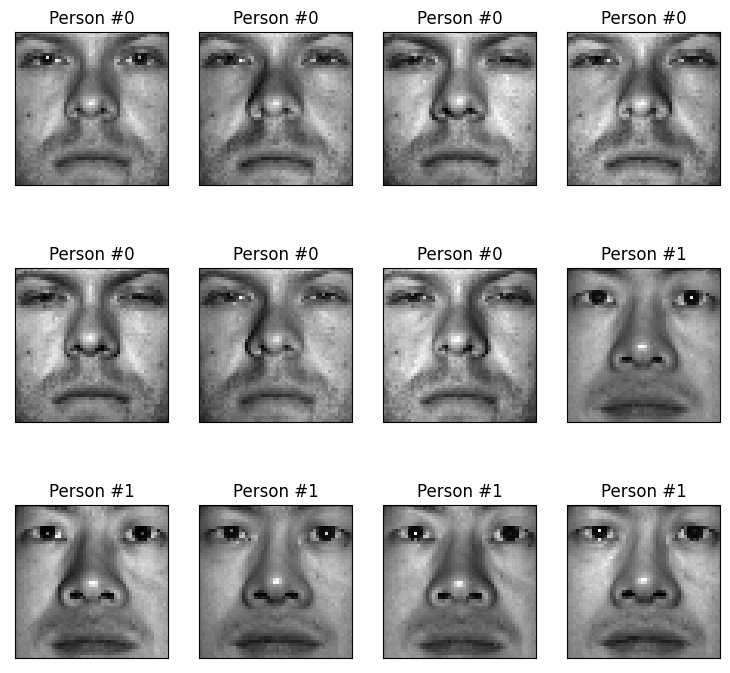

In [8]:
height = width = 50
chosen_images = X_set_1[:12]
chosen_labels = y_set_1[:12]
titles = ['Person #'+str(i) for i in chosen_labels]

plot_gallery(chosen_images, height, width, titles)

### 1.2) Εκπαίδευση μεθόδου Eigenfaces και αναγνώριση προσώπων

#### Υπολογισμός των eigenfaces με την συνάρτηση Eigenfaces
Η συνάρτηση Eigenfaces:
<br>
1. Μεταφέρει τα δεδομένα εισόδου X σε χαμηλότερη διάσταση (eigenspace)
<br>
2. Εξαγάγει τα d principal components (eigenvectors)

In [9]:
def Eigenfaces(X, d):
    pca = PCA(n_components=d, svd_solver='randomized', whiten=True)
    X_train = pca.fit_transform(X)
    eigenvectors = pca.components_.reshape((d, height, width))

    return pca, eigenvectors, X_train

pca_d_9, eigenvectors, X_train_pca_d_9 = Eigenfaces(X_set_1, 9)
y_train = y_set_1

#### Με την συνάρτηση train_and_predict κάνουμε classification με τον knn classifier

In [10]:
def train_and_predict(pca, X, X_train_pca, y_test):
    # Projecting the data onto the eigenspace
    # Applying dimensionality reduction to X

    X_test_pca = pca.transform(X)
    knn_model = KNeighborsClassifier(n_neighbors=1)
    knn_model.fit(X_train_pca,y_train)

    # detecting faces in test set
    y_test_pred = knn_model.predict(X_test_pca)

    return accuracy_score(y_test,y_test_pred)

#### Ακολούθως κάνουμε δοκιμές για d = 9 με κάθε set. Παρατηρούμε, όπως ήταν λογικό πως το accuracy για το Set 1 είναι 100%. Όσο οι εικόνες γίνονται πιο σκοτεινές το accuracy πέφτει. Αν αυξήσουμε το d σε 30 όπως θα κάνουμε παρακάτω θα δούμε ότι παίρνουμε καλύτερο accuracy για τις πιο σκοτεινές εικόνες από όταν χρησιμοποιήσαμε d = 9

In [11]:
# Set 1 - d = 9 - accuracy = 1.0
print(f"Set 1 accuracy: {train_and_predict(pca_d_9, X_set_1, X_train_pca_d_9, y_set_1)}")

# Set 2 - d = 9 - accuracy = 1.0
X_set_2, y_set_2 = loadImages("faces", "Set_2")
print(f"Set 2 accuracy: {train_and_predict(pca_d_9, X_set_2, X_train_pca_d_9, y_set_2)}")

# Set 3 - d = 9 - accuracy = 0.85
X_set_3, y_set_3 = loadImages("faces", "Set_3")
print(f"Set 3 accuracy: {train_and_predict(pca_d_9, X_set_3, X_train_pca_d_9, y_set_3)}")

# Set 4 - d = 9 - accuracy = 0.36
X_set_4, y_set_4 = loadImages("faces", "Set_4")
print(f"Set 4 accuracy: {train_and_predict(pca_d_9, X_set_4, X_train_pca_d_9, y_set_4)}")

# Set 5 - d = 9 - accuracy = 0.13
X_set_5, y_set_5 = loadImages("faces", "Set_5")
print(f"Set 5 accuracy: {train_and_predict(pca_d_9, X_set_5, X_train_pca_d_9, y_set_5)}")


Set 1 accuracy: 1.0
Set 2 accuracy: 1.0
Set 3 accuracy: 0.8583333333333333
Set 4 accuracy: 0.36428571428571427
Set 5 accuracy: 0.13157894736842105


#### Όπως παρατηρούμε για τις πιο σκοτεινές εικόνες ο classifier μας μας δίνει καλύτερες τιμές για το accuracy για d = 30

In [12]:
# Set 1 - d = 30 - accuracy = 1.0
pca_d_30, eigenfaces, X_train_pca_d_30 = Eigenfaces(X_set_1, 30)
print(f"Set 1 accuracy: {train_and_predict(pca_d_30, X_set_1, X_train_pca_d_30, y_set_1)}")

# Set 2 - d = 30 - accuracy = 0.95
print(f"Set 2 accuracy: {train_and_predict(pca_d_30, X_set_2, X_train_pca_d_30, y_set_2)}")

# Set 3 - d = 30 - accuracy = 0.92
print(f"Set 3 accuracy: {train_and_predict(pca_d_30, X_set_3, X_train_pca_d_30, y_set_3)}")

# Set 4 - d = 30 - accuracy = 0.56
print(f"Set 4 accuracy: {train_and_predict(pca_d_30, X_set_4, X_train_pca_d_30, y_set_4)}")

# Set 5 - d = 30 - accuracy = 0.19
print(f"Set 5 accuracy: {train_and_predict(pca_d_30, X_set_5, X_train_pca_d_30, y_set_5)}")

Set 1 accuracy: 1.0
Set 2 accuracy: 0.9583333333333334
Set 3 accuracy: 0.925
Set 4 accuracy: 0.55
Set 5 accuracy: 0.18947368421052632


### 1.3) Οπτικοποίηση 9 κύριων eigenvectors

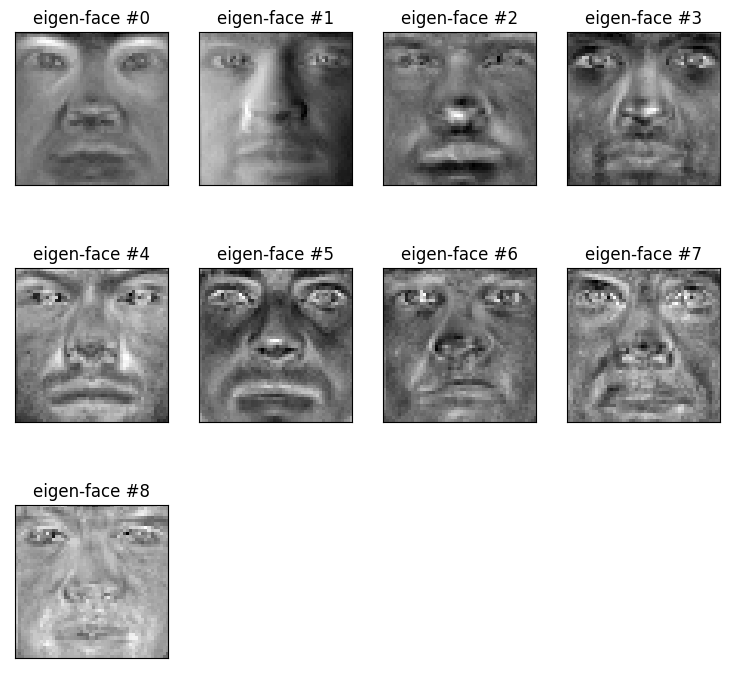

In [14]:
pca_d_9, eigenvectos, X_train_pca_d_9 = Eigenfaces(X_set_1, 9) # X_train_pca_d_9 = data projected in eigenspace
y_train = y_set_1
titles = ['eigen-face #'+str(i) for i in range(eigenvectors.shape[0])]
plot_gallery(eigenvectors, height, width, titles)

### 1.4) Ανακατασκευή εικόνων


In [15]:
def plot_images(reconstructed_imgs):
    num_images = len(reconstructed_imgs)
    num_rows = int(num_images ** 0.5)  # Number of rows in the grid
    num_cols = num_images // num_rows  # Number of columns in the grid

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))

    # Flatten the axes array if it's not already 2-dimensional
    if num_rows == 1:
        axes = [axes]

    # Iterate over the reconstructed images and plot them
    for i, reconstructed_img in enumerate(reconstructed_imgs):
        row = i // num_cols
        col = i % num_cols
        axes[row][col].imshow(reconstructed_img, cmap='gray')
        axes[row][col].axis('off')

    plt.tight_layout()
    plt.show()

Eigenfaces του Set 1 για d = 9 και για d = 30

In [16]:
_, eigenvectors_9, _ = Eigenfaces(X_set_1, 9)
_, eigenvectors_30, _ = Eigenfaces(X_set_1, 30)

Reconstructed images για d = 9 <br>
Παίρνουμε την δεύτερη εικόνα από κάθε set. Παρατηρούμε πως η ποιότητα ανακατασκευής είναι ίδια για κάθε set

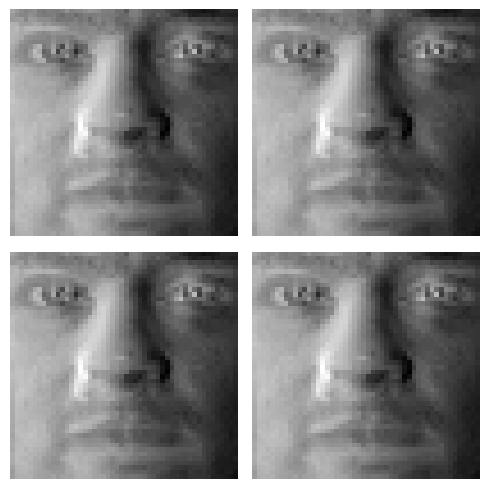

In [17]:
reconstructed_images = []
# Set 2 reconstructed image - d =9 
X_set_2, _ = loadImages("faces", "Set_2")
mean_image = np.mean(X_set_2, axis=0)
reconstruct_img = mean_image[1] + eigenvectors_9[1]
#plot_reconstructed_img(reconstruct_img)
reconstructed_images.append(reconstruct_img)

# Set 3 reconstructed image - d =9
X_set_3, _ = loadImages("faces", "Set_3")
mean_image = np.mean(X_set_3, axis=0)
reconstruct_img = mean_image[1] + eigenvectors_9[1]
#plot_reconstructed_img(reconstruct_img)
reconstructed_images.append(reconstruct_img)

# Set 4 reconstructed image - d =9
X_set_4, _ = loadImages("faces", "Set_4")
mean_image = np.mean(X_set_4, axis=0)
reconstruct_img = mean_image[1] + eigenvectors_9[1]
#plot_reconstructed_img(reconstruct_img)
reconstructed_images.append(reconstruct_img)

# Set 5 reconstructed image - d =9
X_set_5, _ = loadImages("faces", "Set_5")
mean_image = np.mean(X_set_5, axis=0)
reconstruct_img = mean_image[1] + eigenvectors_9[1]
#plot_reconstructed_img(reconstruct_img)
reconstructed_images.append(reconstruct_img)

plot_images(reconstructed_images)

Reconstructed images για d = 30

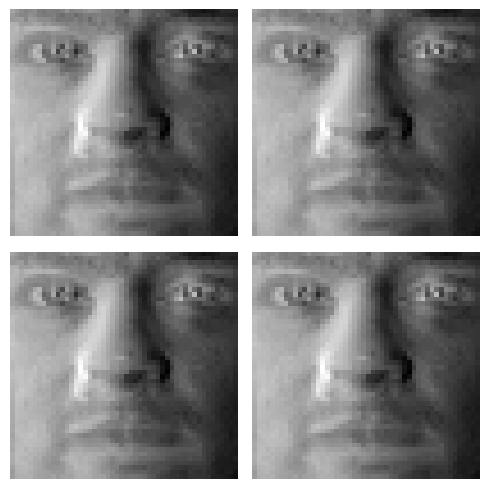

In [18]:
reconstructed_images = []

# Set 2 reconstructed image - d =9 
X_set_2, _ = loadImages("faces", "Set_2")
mean_image = np.mean(X_set_2, axis=0)
reconstruct_img = mean_image[1] + eigenvectors_30[1]
#plot_reconstructed_img(reconstruct_img)
reconstructed_images.append(reconstruct_img)

# Set 3 reconstructed image - d =9
X_set_3, _ = loadImages("faces", "Set_3")
mean_image = np.mean(X_set_3, axis=0)
reconstruct_img = mean_image[1] + eigenvectors_30[1]
#plot_reconstructed_img(reconstruct_img)
reconstructed_images.append(reconstruct_img)

# Set 4 reconstructed image - d =9
X_set_4, _ = loadImages("faces", "Set_4")
mean_image = np.mean(X_set_4, axis=0)
reconstruct_img = mean_image[1] + eigenvectors_30[1]
#plot_reconstructed_img(reconstruct_img)
reconstructed_images.append(reconstruct_img)

# Set 5 reconstructed image - d =9
X_set_5, _ = loadImages("faces", "Set_5")
mean_image = np.mean(X_set_5, axis=0)
reconstruct_img = mean_image[1] + eigenvectors_30[1]
#plot_reconstructed_img(reconstruct_img)
reconstructed_images.append(reconstruct_img)

plot_images(reconstructed_images)

## 1.5) Σύγκριση singular-vectors με eigenvectors

In [19]:
from numpy import diag
from numpy import zeros
from scipy.linalg import svd
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
# Singular-value decomposition
U, s, singular_vectors = svd(X_set_1)
# create m x n Sigma matrix
Sigma = zeros((X_set_1.shape[0], X_set_1.shape[1]))
# populate Sigma with n x n diagonal matrix
Sigma[:X_set_1.shape[0], :X_set_1.shape[0]] = diag(s)
# select
n_elements = 9
Sigma = Sigma[:, :n_elements]
singular_vectors = singular_vectors[:n_elements, :]
# reconstruct
B = U.dot(Sigma.dot(singular_vectors))
print(singular_vectors.shape)

(9, 2500)


Παρατηρούμε ότι υπάρχει ισχυρή ανομοιότητα μεταξύ των eigenvectors και των singular vectors. Αυτό πιθανόν να συμβαίνει λόγω του ότι τα eigenvectors που προκύπτουν από τεχνικές όπως η ανάλυση κύριων συνιστωσών (PCA) έχουν ως στόχο να αιχμαλωτίσουν τη μέγιστη διακύμανση στα δεδομένα. Από την άλλη πλευρά, τα singular vectors που προκύπτουν από την αποσύνθεση ενιαίων τιμών (SVD) επικεντρώνονται στην αποθήκευση των μέγιστων ενιαίων τιμών και τη διατήρηση της γενικής δομής του πίνακα.

In [21]:
eigenvectors_9 = eigenvectors_9.reshape(9,-1)
similarity = cosine_similarity(eigenvectors_9, singular_vectors)
print(similarity)

[[ 1.77356671e-02 -9.99840217e-01  6.17533339e-05  7.49088945e-04
  -1.02811433e-03 -1.79291948e-03  2.36754208e-04  1.75184798e-05
   8.68638431e-05]
 [-2.80703851e-03 -1.13654821e-04 -9.99995607e-01 -3.92625111e-04
   4.48361098e-04  7.22645341e-04 -8.73253448e-05 -5.75762678e-06
  -2.68931474e-05]
 [-8.67376405e-02 -2.46002105e-03  7.06806274e-04 -9.92472976e-01
   5.54386679e-02  6.58462574e-02 -6.25369461e-03 -3.29485366e-04
  -1.40510175e-03]
 [-1.74362118e-01 -4.54587932e-03  1.09863922e-03  8.79002018e-02
   9.30531623e-01  3.08913648e-01 -2.04877844e-02 -8.82938538e-04
  -3.54220943e-03]
 [-1.72738684e-01 -4.32861897e-03  9.77472224e-04  5.71950853e-02
  -3.44176789e-01  9.20540876e-01 -2.96380160e-02 -1.04969403e-03
  -4.02046739e-03]
 [-2.66668512e-02 -6.16446405e-04  1.23640939e-04  5.06769609e-03
  -1.33820007e-02 -4.25090723e-02 -9.98634379e-01 -2.85632861e-04
  -9.06221436e-04]
 [-3.78041024e-03 -7.93298038e-05  1.41718008e-05  4.60947154e-04
  -9.57715174e-04 -2.2292740

## Ερώτημα 2

In [22]:
from keras.datasets import mnist
from sklearn import svm

### 2.1) Κάνουμε load το dataset και το κανονικοποιούμε στο διάστημα [0-1]

In [23]:
def load_normalize_data():
    #https://www.askpython.com/python/examples/load-and-plot-mnist-dataset-in-python
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = np.resize(X_train, (X_train.shape[0], 784)).astype(np.float64)
    X_test = np.resize(X_test, (X_test.shape[0], 784)).astype(np.float64)
    X_train = X_train / np.max(X_train)
    X_test = X_test / np.max(X_test)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = load_normalize_data()

In [24]:
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (60000, 784)
Y_train: (60000,)
X_test:  (10000, 784)
Y_test:  (10000,)


### 2.2) Πειραματισμός με διάφορα kernels

In [25]:
import time
from sklearn.model_selection import GridSearchCV

#### Linear kernel
Από τα πειράματα όπου χρησιμοποιήθηκε ο **linear** kernel παρατηρούμε ότι το πρώτο μοντέλο είναι αυτό που μας έδωσε καλύτερο accuracy και επίσης εκτελέστηκε σε πιο σύντομο διάστημα από τα άλλα μοντέλα. 

Το πρώτο μοντέλο αποδίδει καλυτερα λόγω του ότι έχουμε μικρότερη τιμή για το **C** και η επιφάνεια με την οποία χωρίζουμε τα δεδομένα μας έχει πιο ευρύ περιθώριο. Ακόμα λόγω των δεδομένων μας που δεν είναι ιδιαιτέρως πολύπλοκα το μοντέλο με το χαμηλότερο degree αποδίδει καλύτερα. Τέλος χαμηλότερο gamma οδηγεί επίσης σε πιο ευρύ όριο από την επιφάνεια που χωρίζει τα δεδομένα μας.


In [54]:
"""
Accuracy: 0.9472  Time:  221.05610346794128
Accuracy: 0.9404  Time:  256.22382855415344
Accuracy: 0.931  Time:  410.6912178993225
"""


svc = svm.SVC(kernel='linear', C=0.1, degree=2, gamma=0.001)
start = time.time()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
end = time.time()
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy, " Time: ", end - start)



svc = svm.SVC(kernel='linear', C=1, degree=3, gamma=0.01)
start = time.time()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
end = time.time()
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy, " Time: ", end - start)


svc = svm.SVC(kernel='linear', C=10, degree=3, gamma=0.1)
start = time.time()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
end = time.time()
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy, " Time: ", end - start)


#### RBF kernel
Από τα πειράματα που γίνανε παρατηρούμε πως ο καλύτερος ταξινομητής είναι αυτός με τιμές για τις υπερπαραμέτρους του:
<ul>
<li>kernel = 'rbf'</li>
<li>gamma = 0.01</li>
<li>class_weight = balanced</li>
<li>shrinking = False</li>
</ul>

In [22]:
"""
Accuracy: 0.9132  Time:  1216.4715330600739
Accuracy: 0.9767  Time:  248.708411693573
Accuracy: 0.957  Time:  4990.883631467819
"""

svc = svm.SVC(kernel='rbf', C=0.1, gamma=0.001, class_weight=None, shrinking=True)
start = time.time()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
end = time.time()
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy, " Time: ", end - start)



svc = svm.SVC(kernel='rbf', C=1, gamma=0.01, class_weight='balanced', shrinking=False)
start = time.time()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
end = time.time()
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy, " Time: ", end - start)


svc = svm.SVC(kernel='rbf', C=10, gamma=0.1, class_weight='balanced', shrinking=True)
start = time.time()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
end = time.time()
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy, " Time: ", end - start)

Accuracy: 0.9132  Time:  1216.4715330600739
Accuracy: 0.9767  Time:  248.708411693573
Accuracy: 0.957  Time:  4990.883631467819


In [26]:
def dim_red_svm(var):
    start_time = time.time()
    pca = PCA(n_components=var)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    svm_clf = svm.SVC(kernel='rbf', C=1, gamma=0.01, class_weight='balanced', shrinking=False)
    svm_clf.fit(X_train_pca,y_train)
    y_pred = svm_clf.predict(X_test_pca)
    end_time = time.time()
    print(f"Accuracy: {accuracy_score(y_test, y_pred)} - Components: {pca.n_components_} - Time: {end_time - start_time}")

In [27]:
# variance = 0.70
dim_red_svm(0.70)

# variance = 0.80
dim_red_svm(0.80)

# variance = 0.90
dim_red_svm(0.90)

Accuracy: 0.971 - Components: 26 - Time: 21.05096673965454
Accuracy: 0.9754 - Components: 44 - Time: 22.161171913146973
Accuracy: 0.9775 - Components: 87 - Time: 48.24782681465149


Μπορούμε να παρατηρήσουμε πως όσο αυξάνουμε το variance τόσο αυξάνετε το accuracy. Κάποιοι από τους λόγους που συμβαίνει αυτό είναι:
<br>
<ul>
<li>Μείωση της διαστατικότητας: Το PCA μειώνει τη διαστατικότητα του χώρου χαρακτηριστικών, αποθαρρύνοντας τις πληροφορίες που δεν είναι σημαντικές και επικεντρώνοντας στα πιο διακριτικά χαρακτηριστικά.</li>
<li>Μείωση θορύβου: Το PCA μπορεί να φιλτράρει τον θόρυβο και τις μη σημαντικές διακυμάνσεις στα δεδομένα, καθώς αποσκοπεί στην καταγραφή της υποκείμενης δομής.</li>
</ul>